# EFFIECIENT NET 전이학습

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import os

# 데이터셋 경로
base_path = "/content/drive/MyDrive/DLPROJECT/DATA/Split_Data"
train_path = os.path.join(base_path, "Train")
val_path = os.path.join(base_path, "Validation")
test_path = os.path.join(base_path, "Test")

# 데이터 로드 (이미지 증강 제거)
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen.flow_from_directory(
    val_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# 전이 학습 모델 로드
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# 모델 커스터마이징
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # 이진 분류를 위한 시그모이드 출력층

model = Model(inputs=base_model.input, outputs=x)

# 학습 가능한 층 설정
for layer in base_model.layers:
    layer.trainable = False  # EfficientNetB0의 가중치를 고정

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

Found 648 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# 모델 학습
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

# 고정된 층 해제 및 미세 조정
for layer in base_model.layers:
    layer.trainable = True

# 재학습
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# 테스트 데이터 평가
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 648 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.4969 - loss: 0.7017 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4762 - loss: 0.7036 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5034 - loss: 0.7021 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4923 - loss: 0.6993 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4851 - loss: 0.7018 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4980 - loss: 0.7000 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4656 - loss: 0.6991 - val_accuracy: 0.5000 - val_loss: 0.

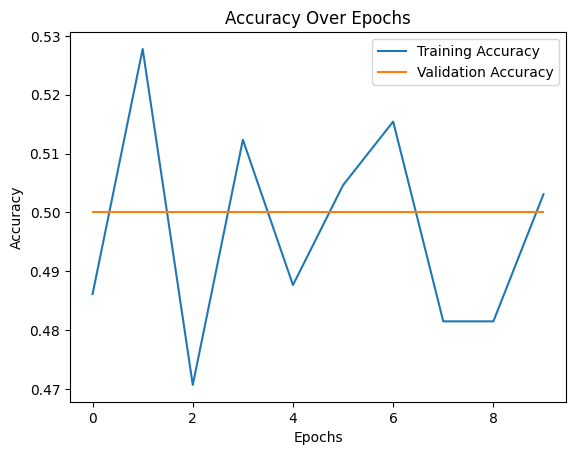

In [ ]:
import matplotlib.pyplot as plt

# 정확도 시각화
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
Confusion Matrix:
[[100   0]
 [100   0]]

Classification Report:
              precision    recall  f1-score   support

     LOGGING       0.50      1.00      0.67       100
 NON-LOGGING       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200

F1 Score (LOGGING): 0.67
F1 Score (NON-LOGGING): 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

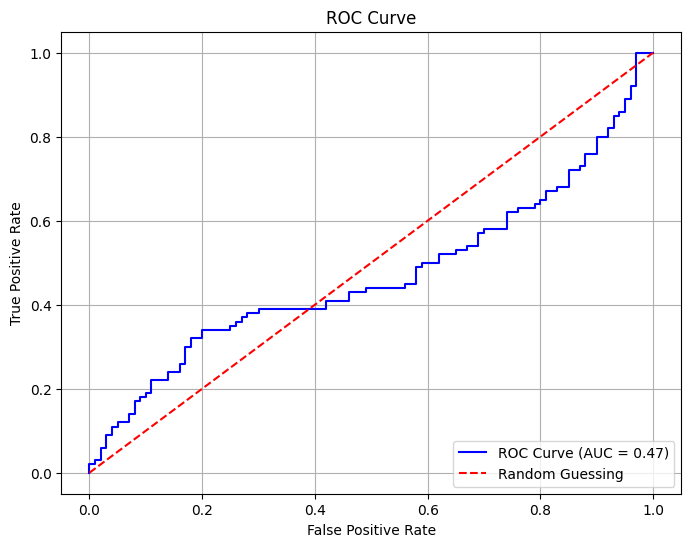

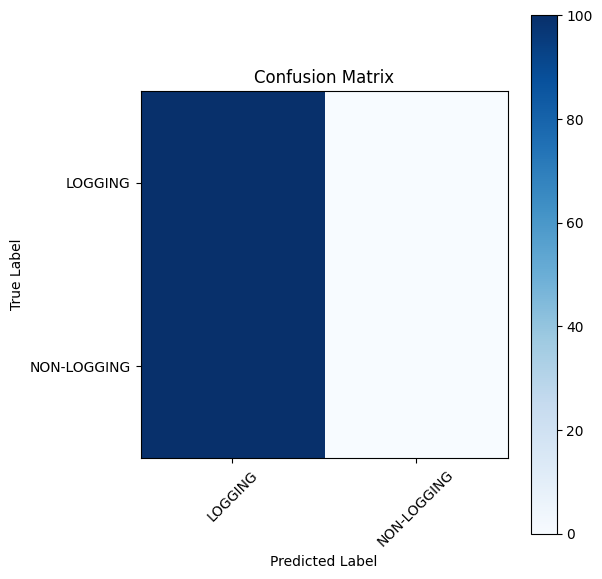

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 테스트 데이터에서 예측 수행
y_pred_probs = model.predict(test_generator)  # 예측 확률값
y_pred = (y_pred_probs > 0.5).astype("int32")  # 확률을 0.5 기준으로 이진 분류
y_true = test_generator.classes  # 실제 클래스

# 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# 분류 보고서 출력
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("\nClassification Report:")
print(report)

# F1 점수 계산
f1_scores = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys(), output_dict=True)
f1_score_logging = f1_scores['LOGGING']['f1-score']
f1_score_nonlogging = f1_scores['NON-LOGGING']['f1-score']
print(f"F1 Score (LOGGING): {f1_score_logging:.2f}")
print(f"F1 Score (NON-LOGGING): {f1_score_nonlogging:.2f}")

# ROC 커브 및 AUC 계산
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# ROC 커브 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 혼동 행렬 시각화
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


> ## 직접 설계한 CNN 모델 사용

In [1]:
# from collections import Counter
# import os

# def count_images(directory):
#     counts = Counter()
#     for class_dir in os.listdir(directory):
#         class_path = os.path.join(directory, class_dir)
#         if os.path.isdir(class_path):
#             counts[class_dir] = len(os.listdir(class_path))
#     return counts

# print("Train Data Distribution:", count_images(train_path))
# print("Validation Data Distribution:", count_images(val_path))
# print("Test Data Distribution:", count_images(test_path))

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import random
import os

# Random Seed 고정
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# 데이터 경로 설정
base_path = "/content/drive/MyDrive/DLPROJECT/DATA/Split_Data"
train_path = os.path.join(base_path, "Train")
val_path = os.path.join(base_path, "Validation")
test_path = os.path.join(base_path, "Test")

# 데이터 전처리
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),  # Mel-Spectrogram 입력 크기
    batch_size=32,
    class_mode='binary',  # 이진 분류
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    seed=SEED
)

# 모델 정의
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # 과적합 방지를 위한 Dropout
    layers.Dense(1, activation='sigmoid')  # 이진 분류
])

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 콜백 설정
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        filepath='/content/drive/MyDrive/DLPROJECT/best_model.keras',  # '.keras'로 변경
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

Found 648 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# 모델 구조 출력
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 학습
history = model.fit(
    train_generator,
    epochs=30,  # 최대 에포크
    validation_data=val_generator,
    callbacks=callbacks
)

# 저장된 모델 로드
best_model = tf.keras.models.load_model('/content/drive/MyDrive/DLPROJECT/best_model.h5')

# 테스트 데이터 평가
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Best Model Test Loss: {test_loss}")
print(f"Best Model Test Accuracy: {test_accuracy}")


Found 648 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/30
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5079 - loss: 0.8670
Epoch 1: val_loss improved from inf to 0.57582, saving model to /content/drive/MyDrive/DLPROJECT/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 569ms/step - accuracy: 0.5160 - loss: 0.8542 - val_accuracy: 0.7100 - val_loss: 0.5758
Epoch 2/30
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7557 - loss: 0.5240
Epoch 2: val_loss improved from 0.57582 to 0.07047, saving model to /content/drive/MyDrive/DLPROJECT/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 364ms/step - accuracy: 0.7639 - loss: 0.5126 - val_accuracy: 1.0000 - val_loss: 0.0705
Epoch 3/30
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9972 - loss: 0.0361
Epoch 3: val_loss improved from 0.07047 to 0.00044, saving model to /content/drive/MyDrive/DLPROJECT/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 37

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/DLPROJECT/best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

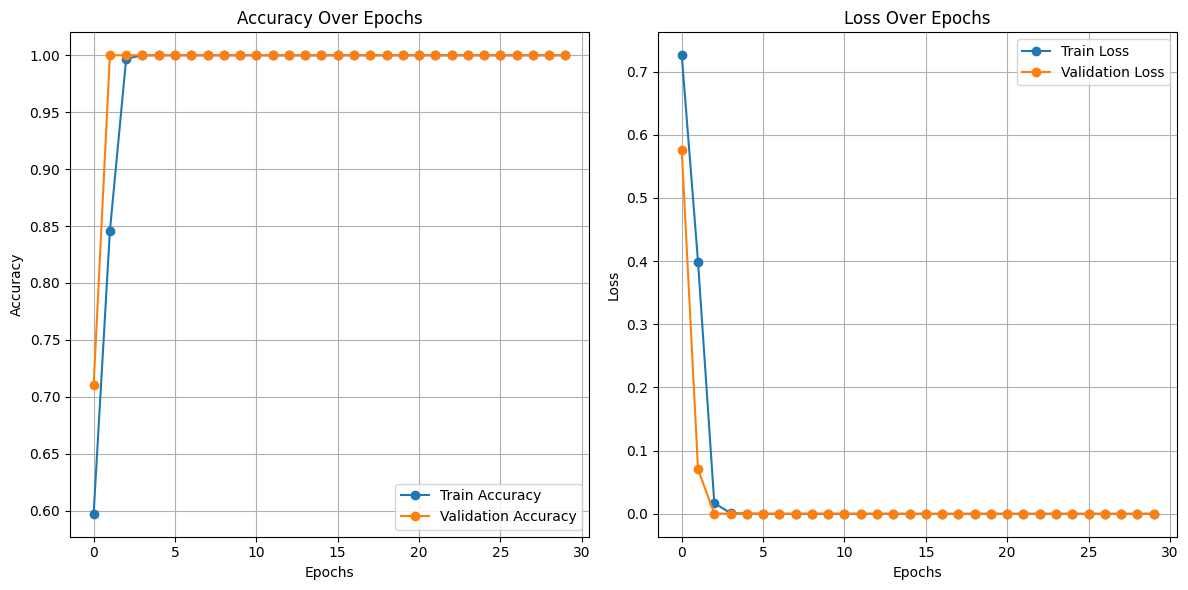

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Accuracy 시각화
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss 시각화
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# 학습 과정 시각화 함수 호출
plot_training_history(history)

Model loaded successfully.
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - accuracy: 1.0000 - loss: 2.4975e-11
Test Loss: 2.4803395448635968e-11
Test Accuracy: 1.0


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step


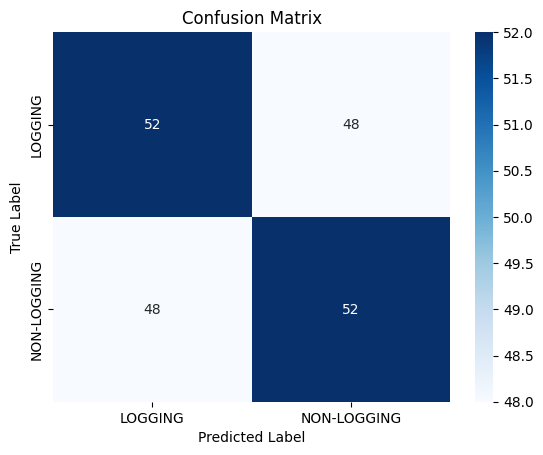


Classification Report:
              precision    recall  f1-score   support

     LOGGING       0.52      0.52      0.52       100
 NON-LOGGING       0.52      0.52      0.52       100

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.52      0.52      0.52       200



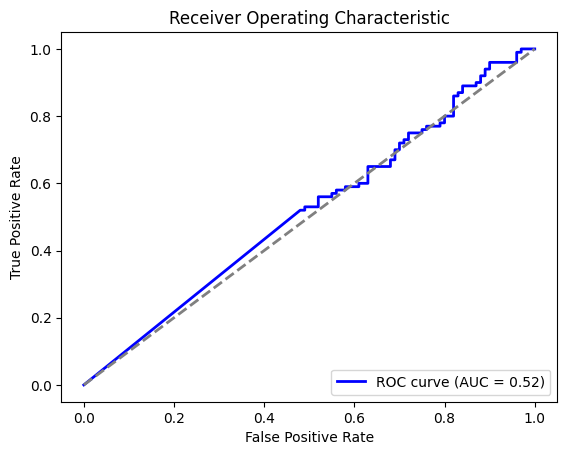

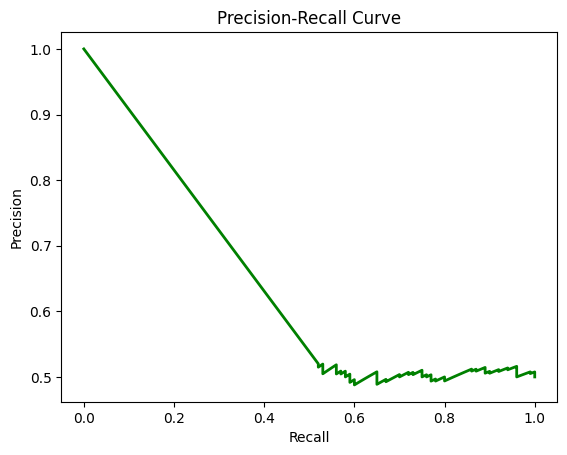

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 저장된 모델 경로
model_path = '/content/drive/MyDrive/DLPROJECT/best_model.keras'

# 모델 로드
model = load_model(model_path)
print("Model loaded successfully.")

# 테스트 데이터 평가
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 테스트 데이터 예측 및 결과 시각화
def evaluate_model(model, test_generator):
    # 테스트 데이터에서 실제 라벨과 예측값 가져오기
    y_true = test_generator.classes  # 실제 라벨
    y_pred_proba = model.predict(test_generator)  # 예측 확률
    y_pred = (y_pred_proba > 0.4).astype("int32")  # 이진 예측값

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)

    plt.figure()
    plt.plot(recall, precision, color='green', lw=2)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

# 모델 평가 및 시각화
evaluate_model(model, test_generator)
